In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from colors import strip_color
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import array
import math
from scipy.stats import norm
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator


%matplotlib inline 

sns.set_style("whitegrid")
sns.set_palette("Blues")

In [2]:
LOG_PATH = Path('./log/')
DATA_PATH = Path('./data/')
PAPER_FIG_PATH = Path('../../ebft-paper/images/')

## LoCs

In [3]:
loc_df = pd.read_csv('./data/diff.csv')
loc_df

def total_locs(df):
    locs = 0
    for _, row in df.iterrows():
        if row['name'].endswith('.go') and row['name'].find('address_list') == -1 and row['name'].find('cpuminer') == -1 and row['name'].find('vrf') == -1:
            print('%s: %d, %d' % (row['name'], int(row['delete']), int(row['add'])))
            locs -= int(row['delete'])
            locs += int(row['add'])
            
    return locs

total_locs(loc_df)

blockchain/accept.go: 5, 5
blockchain/blockindex.go: 10, 39
blockchain/chain.go: 2, 32
blockchain/chainio.go: 0, 21
blockchain/committee.go: 0, 82
blockchain/orazor.go: 0, 231
blockchain/process.go: 1, 50
blockchain/weight.go: 2, 2
chaincfg/extension.go: 0, 102
chaincfg/params.go: 0, 5
config.go: 2, 66
limits_plan9.go: 10, 0
limits_unix.go: 52, 0
limits_windows.go: 10, 0
netsync/interface.go: 0, 5
netsync/manager.go: 14, 164
peer/log.go: 0, 3
peer/peer.go: 1, 9
rpcserver.go: 0, 66
server.go: 1176, 54
serverpeer.go: 0, 1164
wire/common.go: 0, 31
wire/message.go: 0, 4
wire/msgblock.go: 1, 2
wire/msgvote.go: 0, 69


920

## Log processing

In [4]:
def get_files(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    log_folder = '%s_%d_%g_%d_%d_%d' % (extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    data_path = LOG_PATH / log_folder
    log_files = [x for x in data_path.iterdir() if x.name.endswith('.log')]
    dstat_files = [x for x in data_path.iterdir() if x.name.endswith('.csv')]
    return log_files, dstat_files

In [5]:
def _sanitize(s):
    s = strip_color(s)
    s = s.strip('[1;38;5;8m')
    s = s.strip('\n')
    return s

def _get_time(s):
    dt_str = s[0:23]
    return datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')

def get_blocks(log_file):
    blocks = dict()
    for line in open(log_file.absolute()):
        block = dict()
        line = _sanitize(line)
        if line.find('Block submitted via CPU miner accepted') != -1: # mined a block
            blockhash = line.split(' ')[-4].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'mined_time' not in blocks[blockhash]:
                blocks[blockhash]['mined_time'] = _get_time(line)
#         if line.find('PEER: Received block (hash') != -1: # received a block
#             blockhash = line.split(' ')[7].strip(',')
        if line.find('SYNC: received block') != -1: # received a block
            blockhash = line.split(' ')[6].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
#             if 'received_time' not in blocks[blockhash]:
#                 blocks[blockhash]['received_time'] = _get_time(line)
            blocks[blockhash]['received_time'] = _get_time(line)
        if line.find('has been finalised') != -1: # finalised
            blockhash = line.split(' ')[-4]
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'finalised_time' not in blocks[blockhash]:
                blocks[blockhash]['finalised_time'] = _get_time(line)
    
    non_finalised_blocks = dict()
    for blockhash in blocks.keys():
        if 'finalised_time' not in blocks[blockhash]:
            non_finalised_blocks[blockhash] = blocks[blockhash]
            continue
        
#     for blockhash in non_finalised_blocks:
#         del blocks[blockhash]
    
    return blocks, non_finalised_blocks

# lfiles, dfiles = get_files('syncebft', 64, 5, 10)
# blocks, _ = get_blocks(lfiles[3])
# for blockhash in blocks.keys():
#     print(blocks[blockhash])

## Block propagation delay

In [6]:
def get_bpds(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    # dict{block: [gap1, gap2, ...]}
    bpd_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    for lf in lfiles:
        blocks, _ = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in bpd_dict.keys():
                bpd_dict[blockhash] = dict()
                bpd_dict[blockhash]['received_times'] = list()
                bpd_dict[blockhash]['bpds'] = list()
            if 'mined_time' in block.keys():
                bpd_dict[blockhash]['mined_time'] = block['mined_time']
            elif 'received_time' in block.keys():
                bpd_dict[blockhash]['received_times'].append(block['received_time'])
    
    for blockhash, block in bpd_dict.items():
        if 'mined_time' not in block.keys():
            continue
        for received_time in block['received_times']:
            bpd = received_time - block['mined_time']
            bpd_milliseconds = bpd.total_seconds() * 1000
            bpd_dict[blockhash]['bpds'].append(bpd_milliseconds)
    
    for blockhash, block in bpd_dict.items():
        bpd_dict[blockhash]['bpds'] = sorted(bpd_dict[blockhash]['bpds'])
        bpd_dict[blockhash]['bpds-50'] = bpd_dict[blockhash]['bpds'][int(0.5*committee_size):int(0.9*committee_size)]
        bpd_dict[blockhash]['bpds-90'] = bpd_dict[blockhash]['bpds'][int(0.9*committee_size):-1]
        
    return bpd_dict

def save_bpds_stats(extension, committee_sizes, latency, minerblocksizes, block_interval=4, epoch_size=1):
    df = pd.DataFrame()
    for committee_size in committee_sizes:
        for minerblocksize in minerblocksizes:
            bpd_dict = get_bpds(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
            for blockhash, block in bpd_dict.items():
                for bpd in bpd_dict[blockhash]['bpds-50']:
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'blockhash': blockhash,
                        'percent': '50%',
                        'bpd': bpd
                    }
                    df = df.append(line, ignore_index=True)
                for bpd in bpd_dict[blockhash]['bpds-90']:
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'blockhash': blockhash,
                        'percent': '90%',
                        'bpd': bpd
                    }
                    df = df.append(line, ignore_index=True)
                
    df.to_csv(DATA_PATH / 'bpd.csv')
    return df

# bpds_df = save_bpds_stats('none', [256], 2, [10,20,40,60], block_interval=1, epoch_size=1)
# bpds_df

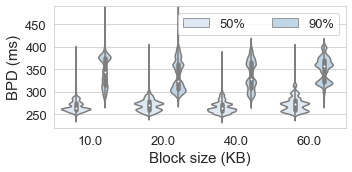

In [7]:
bpds_df = pd.read_csv(DATA_PATH / 'bpd.csv')

def plot_bpd(df):
    filtered_df = df
    plt.figure(figsize=(5,2.5))
    ax = sns.violinplot(x='minerblocksize', y='bpd', hue='percent', hue_order=['50%', '90%'], data=filtered_df)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Block size (KB)', fontsize=15)
    plt.ylabel('BPD (ms)', fontsize=15)
    plt.ylim([220, 490])
    ax.legend(handles=ax.legend_.legendHandles, labels=['50%', '90%'], fontsize=13, ncol=2)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'bpd.pdf')
    plt.show()

plot_bpd(bpds_df)

## Block finalisation latency

In [7]:
def get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize, block_interval=1, epoch_size=1):
    # dict{block: [gap1, gap2, ...]}
    delay_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    for lf in lfiles:
        blocks, _ = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in delay_dict.keys():
                delay_dict[blockhash] = dict()
                delay_dict[blockhash]['finalised_times'] = list()
            if 'mined_time' in block:
                delay_dict[blockhash]['mined_time'] = block['mined_time']
            if 'finalised_time' in block:
                 delay_dict[blockhash]['finalised_times'].append(block['finalised_time'])
    
    latencies = []
    for block, block_delay in delay_dict.items():
        if 'mined_time' not in block_delay:
            continue
        for finalised_time in block_delay['finalised_times']:
            latency = finalised_time - block_delay['mined_time']
            latencies.append(latency.seconds*1000 + latency.microseconds/1000)
    
    latencies_array = np.array(latencies)
    return latencies_array.mean(), latencies_array.std()

def save_latency_stats(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    mean, std = get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'mean': mean, 
                        'std': std
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'latency.csv')
    return df

# latency_df = save_latency_stats(['syncebft', 'psyncebft'], [64,128, 256], [2], [20,40,80,160])
# latency_df

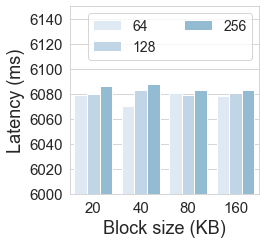

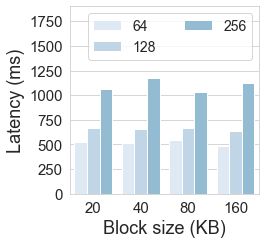

In [17]:
latency_df = pd.read_csv(DATA_PATH / 'latency.csv')

extensions = ['syncebft', 'psyncebft']
committee_sizes = [64,128,256]
latency = 5
minerblocksizes = [10, 20, 40, 60]

def plot_latency(df, extension):
    plt.figure(figsize=(3.8, 3.5))
    filtered_df = df[df['extension']==extension]
    filtered_df = filtered_df.astype({"minerblocksize": int})

    sns.set_palette("Blues")
#     for minerblocksize in minerblocksizes:
#         lines = df[(df['extension']==extension) & (df['committee_size'].isin(committee_sizes)) & (df['latency']==latency) & (df['minerblocksize']==minerblocksize)]
#         delay_means = lines['mean']
#         delay_stds = lines['std']
# #         plt.errorbar(committee_sizes, delay_means, yerr=delay_stds, label="%dMB" % minerblocksize)
#         plt.plot(committee_sizes, delay_means, '-*', label="%dMB" % minerblocksize, markersize=15)
    
    ax = sns.barplot(data=filtered_df, x='minerblocksize', y='mean', hue='committee_size')
    
    if extension == 'syncebft':
        plt.ylim([3*2*1000, (3*2+0.15)*1000])
    else:
        plt.ylim([0, 1900])
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Block size (KB)', fontsize=18)
    plt.ylabel('Latency (ms)', fontsize=18)
    ax.legend(handles=ax.legend_.legendHandles, labels=['64', '128', '256'], fontsize=14, ncol=2)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / ('latency-%s.pdf' % extension))
    plt.show()

plot_latency(latency_df, 'syncebft')
plot_latency(latency_df, 'psyncebft')

# TODO (RH): add pipeline

## Network bandwidth utilisation

In [9]:
def get_bw_util(extension, committee_size, latency, minerblocksize, block_interval=1, epoch_size=1):
    _, dfiles = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    recvs, sends = [], []
    for dfile in dfiles:
        df = pd.read_csv(dfile.absolute(), skiprows=6)
        recvs.append(df['recv'].mean())
        sends.append(df['send'].mean())
    return np.array(recvs).mean(), np.array(sends).mean() # all in Bytes

def save_bw_util(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    recv, send = get_bw_util(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'recv': recv, 
                        'send': send
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'bw_util.csv')
    return df

# bw_df = save_bw_util(['syncebft', 'psyncebft'], [64,128,256], [2], [20,40,80,160])
# bw_df


# for minerblocksize in [20,40,80,160]:
#     print(get_bw_util('none', 64, 2, minerblocksize, block_interval=1, epoch_size=1))

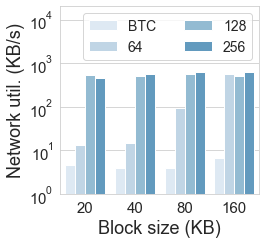

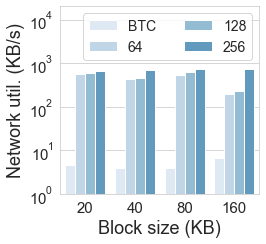

In [102]:
bw_df = pd.read_csv(DATA_PATH / 'bw_util.csv')

def plot_bw_util(df, extension, committee_sizes, minerblocksizes):
    plt.figure(figsize=(3.8, 3.5))
    filtered_df = df[df['extension'] == extension]
    filtered_df = filtered_df.astype({"minerblocksize": int})

    total_utils = list()
    for index, row in filtered_df.iterrows():
        total_utils.append((row['recv'] + row['send'])/1000)
    filtered_df.insert(loc=1, column="total", value=total_utils)
    ax = sns.barplot(x='minerblocksize', y='total', hue='committee_size', data=filtered_df)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Block size (KB)', fontsize=18)
    plt.ylabel('Network util. (KB/s)', fontsize=18)
    plt.ylim([1, 20000])
    plt.yscale('log')
    ax.legend(handles=ax.legend_.legendHandles, labels=['BTC', '64', '128', '256'], fontsize=14, ncol=2)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / ('bw-util-%s.pdf' % extension))
    plt.show()

plot_bw_util(bw_df, 'syncebft', [64,128,256], [20,40,80,160])
plot_bw_util(bw_df, 'psyncebft', [64,128,256], [20,40,80,160])

## Fork rate

- extension: psync
- committee size: 128
- block size: 10, 20, 40, 60
- interval: 1, 2, 3, 4

In [23]:
def get_fork_rates(extension, committee_size, latency, minerblocksize, block_interval=1):
    fork_rates = list()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval=block_interval)
    for lf in lfiles:
        blocks, non_finalised_blocks = get_blocks(lf)
        if len(blocks)+len(non_finalised_blocks) == 0:
            continue
        fork_rate = len(non_finalised_blocks) / len(blocks)
        fork_rates.append(fork_rate)
    
    return np.array(fork_rates)

def save_fork_rates(extensions, committee_sizes, latencies, minerblocksizes, block_intervals):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    for block_interval in block_intervals:
                        frs = get_fork_rates(extension, committee_size, latency, minerblocksize, block_interval)
                        line = {
                            'extension': extension, 
                            'committee_size': committee_size, 
                            'latency': latency, 
                            'minerblocksize': minerblocksize, 
                            'block_interval': block_interval,
                            'mean': frs.mean(), 
                            'std': frs.std()
                        }
                        df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'fork_rates.csv')
    return df

fork_rates_df = save_fork_rates(['psyncebft'], [256], [2], [20,40,80,160], [1,2,4])
fork_rates_df

# for minerblocksize in [20,40,80,160]:
#     print(get_fork_rates('psyncebft', 256, 2, minerblocksize, block_interval=2).mean())

,block_interval,committee_size,extension,latency,mean,minerblocksize,std
0,1.0,256.0,psyncorazor,2.0,0.690560,20.0,0.046607
1,2.0,256.0,psyncorazor,2.0,0.854692,20.0,0.035821
2,4.0,256.0,psyncorazor,2.0,0.836317,20.0,0.088486
3,1.0,256.0,psyncorazor,2.0,0.718194,40.0,0.039895
4,2.0,256.0,psyncorazor,2.0,0.844450,40.0,0.060412
5,4.0,256.0,psyncorazor,2.0,0.763486,40.0,0.054387
6,1.0,256.0,psyncorazor,2.0,0.696322,80.0,0.041725
7,2.0,256.0,psyncorazor,2.0,0.803281,80.0,0.052374
8,4.0,256.0,psyncorazor,2.0,0.853238,80.0,0.053113
9,1.0,256.0,psyncorazor,2.0,0.689447,160.0,0.046422


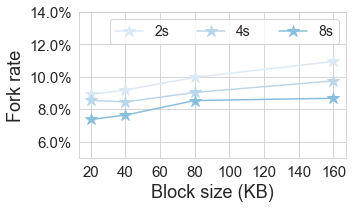

In [19]:
fork_rates_df = pd.read_csv(DATA_PATH / 'fork_rates.csv')

def plot_fork_rates(df):
    plt.figure(figsize=(5, 3))
    
    filtered_df = df[(df['extension'] == 'psyncebft')]
    filtered_df = filtered_df.astype({"minerblocksize": int})

#     ax = sns.lineplot(x='minerblocksize', y='mean', hue='block_interval', data=filtered_df)

    for block_interval in [1,2,4]:
        filtered_dff = filtered_df[filtered_df['block_interval'] == block_interval]
        plt.plot(filtered_dff['minerblocksize'], filtered_dff['mean'], '-*', label="%ds"%(2*block_interval), markersize=13)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))
    plt.xlabel('Block size (KB)', fontsize=18)
    plt.ylabel('Fork rate', fontsize=18)
    plt.ylim([0.05, 0.14])
#     ax.legend(handles=ax.legend_.legendHandles, labels=['2s', '4s', '8s'], fontsize=14, ncol=3)
    plt.legend(fontsize=14, ncol=3)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'fork-rate.pdf')
    plt.show()

plot_fork_rates(fork_rates_df)

# TODO (RH) add baseline, too small

## Razor throughput vs latency

- committee size: 256
- block interval: 2s
- block size: {10, 50, 100, 150, 200}
- epoch size: {1, 5, 10}

In [21]:
tx_size = 512

def get_tps_latency(extension, committee_size, latency, minerblocksize, block_interval, epoch_size):
    tps = minerblocksize*1024/tx_size/(block_interval*latency)
    mean_latency, _ = get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    return tps, mean_latency

def save_tps_latency_stats(tuples): # latency, epoch_size
    extension = 'psyncebft'
    committee_size = 256
    minerblocksize = 160
    latency = [0.5, 0.2, 0.1]
    block_interval = 1
    df = pd.DataFrame()
    for t in tuples:
        latency = t[0]
        epoch_size = t[1]
        tps, mean_latency = get_tps_latency(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
        bpd_dict = get_bpds(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
        bpd_list = list()
        for blockhash, bpds in bpd_dict.items():
            bpd_list.extend(bpds['bpds'])
        bpd = np.array(bpd_list).mean()
#         bpd = bpds_arr[np.where(bpds_arr < 1000000)].mean()
        line1 = {
            'extension': extension, 
            'committee_size': committee_size, 
            'latency': latency, 
            'minerblocksize': minerblocksize, 
            'epoch_size': epoch_size,
            'tps': tps, 
            'type': 'bpd',
            'value': bpd
        }
        df = df.append(line1, ignore_index=True)
        line2 = {
            'extension': extension, 
            'committee_size': committee_size, 
            'latency': latency, 
            'minerblocksize': minerblocksize, 
            'epoch_size': epoch_size,
            'tps': tps, 
            'type': 'latency',
            'value': mean_latency
        }
        df = df.append(line2, ignore_index=True)

    df.to_csv(DATA_PATH / 'tps_latency.csv')
    return df

tps_latency_df = save_tps_latency_stats(
    [
        [0.5, 4],
        [0.2, 10],
        [0.1, 20],
    ]
)
tps_latency_df

,committee_size,epoch_size,extension,latency,minerblocksize,tps,type,value
0,256.0,4.0,psyncorazor,0.5,160.0,640.0,bpd,1360.968724
1,256.0,4.0,psyncorazor,0.5,160.0,640.0,latency,2289.208939
2,256.0,10.0,psyncorazor,0.2,160.0,1600.0,bpd,2192.376279
3,256.0,10.0,psyncorazor,0.2,160.0,1600.0,latency,3448.723245
4,256.0,20.0,psyncorazor,0.1,160.0,3200.0,bpd,1860.422157
5,256.0,20.0,psyncorazor,0.1,160.0,3200.0,latency,7726.744307


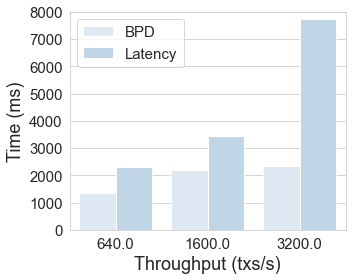

In [37]:
def format_func(value, tick_number=None):
    num_thousands = 0 if abs(value) < 1000 else int(np.floor(np.log10(abs(value))/3))
    value = round(value / 1000**num_thousands, 2)
    return f'{value:g}'+' KMGTPEZY'[num_thousands]

def plot_tps_latency(df):
    plt.figure(figsize=(5, 4))
    
    filtered_df = df
    filtered_df.astype({"tps": int})

    ax = sns.barplot(x='tps', y='value', hue='type', data=filtered_df)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([0, 8000])
    plt.xlabel('Throughput (txs/s)', fontsize=18)
    plt.ylabel('Time (ms)', fontsize=18)
    ax.legend(handles=ax.legend_.legendHandles, labels=['BPD', 'Latency'], fontsize=15, ncol=1, loc='upper left')
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'tps-latency.pdf')
    plt.show()

tps_latency_df = pd.read_csv(DATA_PATH / 'tps_latency.csv')
plot_tps_latency(tps_latency_df)

## Razor vs HotStuff

- extension: psync
- committee size: [4, 8, 16, 32, 64]
- block size: 160
- epoch size: 4

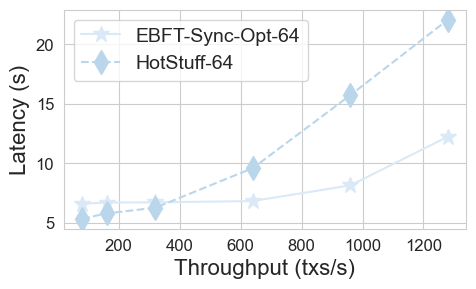

In [11]:
def plot_tps_latency_vs_hs(df):
    plt.figure(figsize=(5, 3))
    
    for extension in ['psyncebft', 'hotstuff']:
        label = "EBFT-Sync-Opt-64" if extension == 'psyncebft' else 'HotStuff-64'
        marker = '-*' if extension == 'psyncebft' else '--d'
        filtered_df = df[df['extension'] == extension]
        plt.plot(filtered_df['tps'], filtered_df['value']/1000, marker, label=label, markersize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Throughput (txs/s)', fontsize=16)
    plt.ylabel('Latency (s)', fontsize=16)
#     plt.ylim([0.05, 0.14])
#     ax.legend(handles=ax.legend_.legendHandles, labels=['2s', '4s', '8s'], fontsize=14, ncol=3)
    plt.legend(fontsize=14, ncol=1)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'tps-latency-razor-hs.pdf')
    plt.show()

tps_latency_vs_df = pd.read_csv(DATA_PATH / 'tps_latency_razor_vs_hs.csv')
plot_tps_latency_vs_hs(tps_latency_vs_df)

## Razor vs HotStuff under attacks

- 16 nodes
- block size: 400 KB

In [12]:
def get_bamboo_exp_data(protocol, n, f, attack, block_size):
    filename = '../../bamboo/evaluation/data/{}-{}-{}-{}-{}.csv'.format(protocol, n, f, attack, block_size)
    df = pd.read_csv(filename)
    return {
        "throughput": df.iloc[2][1],
        "latency": df.iloc[1][1]
    }
    
get_bamboo_exp_data('hotstuff', 16, 1, 'fork', 400)

{'throughput': 607.2562203396486, 'latency': 4981.352626648341}

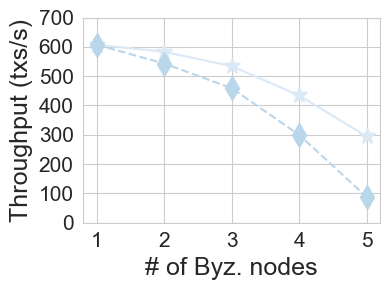

In [45]:
def plot_f_tps_vs_hs_fork():
    plt.figure(figsize=(4, 3))
    
    fs = [1,2,3,4,5]

    ebft_data = [get_bamboo_exp_data('lbft', 16, f, 'fork', 400) for f in fs]
    ebft_df = pd.DataFrame(ebft_data)
    plt.plot(fs, ebft_df['throughput'], '-*', label='EBFT-PSync-Opt-16', markersize=12)

    hs_data = [get_bamboo_exp_data('hotstuff', 16, f, 'fork', 400) for f in fs]
    hs_df = pd.DataFrame(hs_data)
    plt.plot(fs, hs_df['throughput'], '--d', label='Hotstuff-16', markersize=12)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('# of Byz. nodes', fontsize=18)
    plt.ylabel('Throughput (txs/s)', fontsize=18)
    plt.ylim([0, 700])
    # plt.legend(fontsize=12, ncol=1)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'plot-f-tps-vs-hs-fork.pdf')

    plt.show()

plot_f_tps_vs_hs_fork()

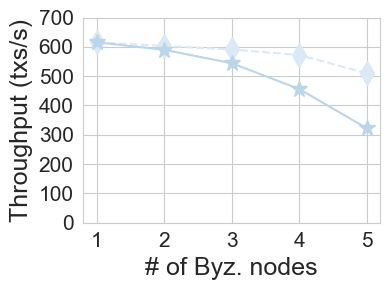

In [52]:
def plot_f_tps_vs_hs_silence():
    plt.figure(figsize=(4, 3))
    
    fs = [1,2,3,4,5]

    ebft_data = [get_bamboo_exp_data('lbft', 16, f, 'silence', 400) for f in fs]
    ebft_df = pd.DataFrame(ebft_data)
    plt.plot(fs, ebft_df['throughput'], '--d', label='EBFT-PSync-Opt-16', markersize=12)

    hs_data = [get_bamboo_exp_data('hotstuff', 16, f, 'silence', 400) for f in fs]
    hs_df = pd.DataFrame(hs_data)
    plt.plot(fs, hs_df['throughput'], '-*', label='Hotstuff-16', markersize=12)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('# of Byz. nodes', fontsize=18)
    plt.ylabel('Throughput (txs/s)', fontsize=18)
    plt.ylim([0, 700])

    # plt.legend(fontsize=12, ncol=1)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'plot-f-tps-vs-hs-silence.pdf')
    plt.show()

plot_f_tps_vs_hs_silence()

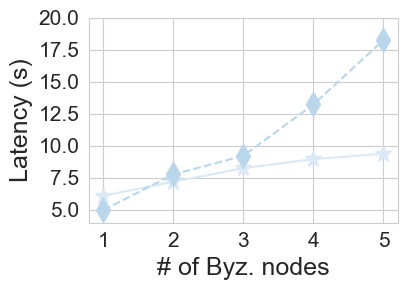

In [53]:
def plot_f_latency_vs_hs_fork():
    plt.figure(figsize=(4, 3))
    
    fs = [1,2,3,4,5]

    ebft_data = [get_bamboo_exp_data('lbft', 16, f, 'fork', 400) for f in fs]
    ebft_df = pd.DataFrame(ebft_data)
    plt.plot(fs, ebft_df['latency']/1000, '-*', label='EBFT-PSync-Opt', markersize=12)

    hs_data = [get_bamboo_exp_data('hotstuff', 16, f, 'fork', 400) for f in fs]
    hs_df = pd.DataFrame(hs_data)
    plt.plot(fs, hs_df['latency']/1000, '--d', label='Hotstuff', markersize=12)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('# of Byz. nodes', fontsize=18)
    plt.ylabel('Latency (s)', fontsize=18)
    # plt.legend(fontsize=14, ncol=1)
    plt.ylim([4, 20])

    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'plot-f-latency-vs-hs-fork.pdf')
    plt.show()

plot_f_latency_vs_hs_fork()

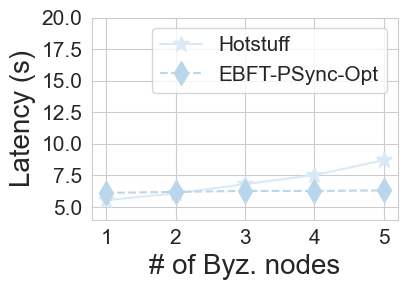

In [57]:
def plot_f_latency_vs_hs_silence():
    plt.figure(figsize=(4, 3))
    
    fs = [1,2,3,4,5]

    hs_data = [get_bamboo_exp_data('hotstuff', 16, f, 'silence', 400) for f in fs]
    hs_df = pd.DataFrame(hs_data)
    plt.plot(fs, hs_df['latency']/1000, '-*', label='Hotstuff', markersize=12)

    ebft_data = [get_bamboo_exp_data('lbft', 16, f, 'silence', 400) for f in fs]
    ebft_df = pd.DataFrame(ebft_data)
    plt.plot(fs, ebft_df['latency']/1000, '--d', label='EBFT-PSync-Opt', markersize=12)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('# of Byz. nodes', fontsize=20)
    plt.ylabel('Latency (s)', fontsize=20)
    plt.ylim([4, 20])

    plt.legend(fontsize=15, ncol=1)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'plot-f-latency-vs-hs-silence.pdf')
    plt.show()

plot_f_latency_vs_hs_silence()